# BOW

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle
import numpy as np
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from torch.autograd import Variable
from global_parser import parser
from glove import read_glove
from vocabulary import Vocabulary
from split_label import SplitLabel
import matplotlib.pyplot as plt

In [15]:
parser.read("../data/bow.config")

['../data/bow.config']

In [16]:
class BagOfWords(nn.Module):

    def __init__(self, tagset_size, word_embeddings, file_path):
        self.embedding_dim = int(parser['Network Structure']['word_embedding_dim'])
        self.hidden_dim = int(self.embedding_dim*2/3)
        # self.hidden_dim = 128

        super(BagOfWords, self).__init__()

        self.word_embeddings = word_embeddings

        self.hidden2tag = nn.Linear(self.embedding_dim, self.hidden_dim)

        self.activation_function1 = nn.Tanh()

        self.hidden3tag = nn.Linear(self.hidden_dim, tagset_size)

    def forward(self, sentence):
        sentence_vector = self.word_embeddings(sentence)
        sentence_vector = torch.mean(sentence_vector, dim=0)
        tag_space = self.hidden2tag(sentence_vector)

        tag_space = self.activation_function1(tag_space)

        tag_space = self.hidden3tag(tag_space)

        tag_scores = F.log_softmax(tag_space, dim = -1)

        return tag_scores.unsqueeze(0)

In [17]:
# train
pretrained = eval(parser['Options for model']['pretrained'])
freeze = eval(parser['Options for model']['freeze'])
train_path = parser['Paths To Datasets And Evaluation']['path_train']
word_dim = parser['Network Structure']['word_embedding_dim']
# learning_rate = float(parser['Hyperparameters']['lr_param'])
model_type = parser['Options for model']['model']
epoch_number = int(parser['Model Settings']['epoch'])
if pretrained:
    if freeze:
        print("Training pretrained and freeze", model_type, "model...")
    else:
        print("Training pretrained and fine-tuning", model_type, "model...")
    print()
    glove_path = parser['Using pre-trained Embeddings']['path_pre_emb']
    vec = read_glove(glove_path)
    voca = Vocabulary("train", word_dim)
    voca.set_word_vector(vec)
    voca.from_word2vect_word2ind()
    voca.from_word2vect_wordEmbeddings(freeze)
    word_emb = voca.get_word_embeddings()
else:
    print("Training random", model_type, "model...")
    print()
    voca = Vocabulary("train", word_dim)
    voca.setup('../data/train.txt')
    word_emb = voca.get_word_embeddings()
features,labels = SplitLabel(train_path).generate_sentences()

tag_to_ix = {}
id = 0
for l in labels:
    if l not in tag_to_ix.keys():
        tag_to_ix[l] = id
        id += 1

model = BagOfWords(len(tag_to_ix), word_emb, "../data/bow.config")

loss_function = nn.NLLLoss()

accuracy_list = []
f1_list = []
lrs = np.array([ 0.01*1.5**j for j in range(0,11)])
lr_list = lrs.tolist()
#lrs = np.arange(0.01, 0.1, 0.01)
for lr in lrs:
    print("Using learning rate", lr)
    optimizer = optim.SGD(model.parameters(), lr=lr)
    #optimizer = optim.Adam(model.parameters(), lr=0.05)
    #optimizer = torch.optim.Adam(model.parameters(), lr= 0.01)

    for epoch in range(epoch_number):  # again, normally you would NOT do 300 epochs, it is toy data
        for sentence, tags in zip(features, labels):
            # Step 1. Remember that Pytorch accumulates gradients.
            # We need to clear them out before each instance
            model.zero_grad()

            # Step 2. Get our inputs ready for the network, that is, turn them into
            # Tensors of word indices.
            sentence_in = voca.get_sentence_ind(sentence,"Bow")
            targets = torch.tensor([tag_to_ix[tags]],dtype=torch.long)

            # Step 3. Run our forward pass.
            tag_scores = model.forward(sentence_in)
            #
            # Step 4. Compute the loss, gradients, and update the parameters by
            #  calling optimizer.step()
            loss = loss_function(tag_scores, targets)

            loss.backward()
            optimizer.step()

        print("Epoch", epoch)
    print()

    test_path = parser['Paths To Datasets And Evaluation']['path_dev']
    features, labels = SplitLabel(test_path).generate_sentences()

    with torch.no_grad():
        y_true = []
        y_pred = []
        lr_list = []
        
        most_error_label = {}
        for sentence, tags in zip(features,labels):
            sentence_in = voca.get_sentence_ind(sentence,"Bow")
            tag_scores = model.forward(sentence_in)
            ind = torch.argmax(tag_scores)
            y_pred.append(ind)
            y_true.append(tag_to_ix[tags])

            if tag_to_ix[tags] != ind:
                if tags not in most_error_label.keys():
                    most_error_label[tags] = 1
                else:
                    most_error_label[tags] += 1

        most_error_label = sorted(most_error_label.items(), key=lambda item: item[1], reverse=True)[:3]
        accuracy = accuracy_score(y_true,y_pred)
        accuracy_list.append(accuracy)
        f1 = f1_score(y_true,y_pred,average='macro')
        f1_list.append(f1)
        print("Learning rate: Accuracy", accuracy)
        print("F1-score", f1)
        print()
#         print("Confusion_matrix \n", confusion_matrix(y_true,y_pred))
#         print("First three most frequent misclassifed label:",most_error_label)

Training pretrained and fine-tuning bow model...

Using learning rate 0.01
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9

Learning rate: Accuracy 0.7326007326007326
F1-score 0.5204377522609768

Using learning rate 0.015
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9

Learning rate: Accuracy 0.9413919413919414
F1-score 0.8051139172128128

Using learning rate 0.0225
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9

Learning rate: Accuracy 0.9945054945054945
F1-score 0.9669887325231152

Using learning rate 0.03375
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9

Learning rate: Accuracy 0.9963369963369964
F1-score 0.9955808080808081

Using learning rate 0.050625
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9

Learning rate: Accuracy 0.9945054945054945
F1-score 0.992867655383222

Using learning rate 0.0759375
Epoch 0
Epoch 1
Epoch

In [19]:
print("accuracies among all learning rates:", accuracy_list)
print("accuracies among all learning rates:", f1_list)
lr_list = lrs.tolist()

argmax_accu = accuracy_list.index(max(accuracy_list))
argmax_f1 = f1_list.index(max(f1_list))
ps_x_accu = lr_list[argmax_accu]
ps_y_accu = accuracy_list[argmax_accu]

ps_x_f1 = lr_list[argmax_f1]
ps_y_f1 = f1_list[argmax_f1]

print("the optimum one is ", ps_x_accu)

accuracies among all learning rates: [0.7326007326007326, 0.9413919413919414, 0.9945054945054945, 0.9963369963369964, 0.9945054945054945, 0.9945054945054945, 0.9945054945054945, 0.9945054945054945, 0.5586080586080586, 0.336996336996337, 0.28205128205128205]
accuracies among all learning rates: [0.5204377522609768, 0.8051139172128128, 0.9669887325231152, 0.9955808080808081, 0.992867655383222, 0.992867655383222, 0.992867655383222, 0.992867655383222, 0.2871371859106829, 0.08240058628190045, 0.07148094643426026]
the optimum one is  0.03375


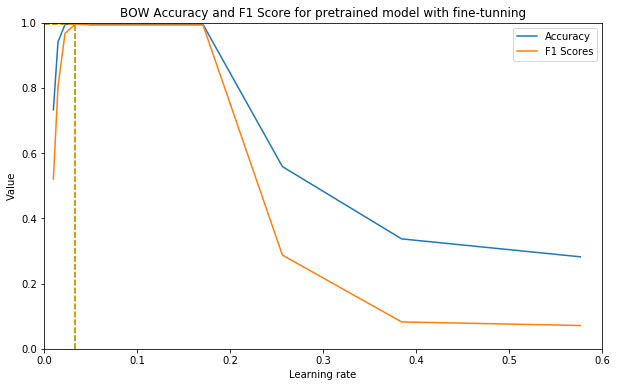

In [20]:

plt.figure(figsize=(10,6))
plt.xlim([0, 0.6])
plt.ylim([0, 1])
plt.plot(lr_list,accuracy_list,label='Accuracy')
plt.plot(lr_list,f1_list,label='F1 Scores')
plt.plot([0, ps_x_accu],[ps_y_accu,ps_y_accu], c='r', linestyle = '--')
plt.plot([ps_x_accu, ps_x_accu],[0,ps_y_accu], c='r', linestyle = '--')



plt.plot([0, ps_x_f1],[ps_y_f1,ps_y_f1], c='y', linestyle = '--')
plt.plot([ps_x_f1, ps_x_f1],[0,ps_y_f1], c='y', linestyle = '--')

ps_coord_str_accu = "max: " + str((lr_list[argmax_accu],round(accuracy_list[argmax_accu],3)))
plt.title("BOW Accuracy and F1 Score for pretrained model with fine-tunning")
plt.xlabel('Learning rate')
plt.ylabel('Value')
plt.legend()
# plt.show()
plt.savefig("../visualization/out_bow_pre_fine.jpg")

# BiLSTM

In [33]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import pickle
from sklearn.metrics import f1_score, accuracy_score, confusion_matrix
from global_parser import parser
from glove import read_glove
from split_label import SplitLabel
from vocabulary import Vocabulary
import matplotlib.pyplot as plt

In [34]:
parser.read("../data/bilstm.config")

['../data/bilstm.config']

In [35]:
class BiLSTMTagger(nn.Module):

    def __init__(self, tagset_size, file_path, word_embeddings):
        self.embedding_dim = int(parser['Network Structure']['word_embedding_dim'])
        self.batch_size = int(parser['Network Structure']['batch_size'])

        super(BiLSTMTagger, self).__init__()
        self.hidden_dim = int(parser['Network Structure']['hidden_dim'])

        self.bilstm = nn.LSTM(self.embedding_dim, self.hidden_dim, bidirectional=True)
        self.word_embeddings = word_embeddings
        self.hidden2tag = nn.Linear(self.hidden_dim * 2, tagset_size)

    def forward(self, sentence_in):
        embeds = self.word_embeddings(sentence_in)
        bilstm_out, (h_n, c_n) = self.bilstm(embeds.view(len(embeds), 1, -1))

        out = torch.hstack((h_n[-2, :, :], h_n[-1, :, :]))
        tag_space = self.hidden2tag(out)

        tag_scores = F.log_softmax(tag_space, dim = -1)

        return tag_scores

In [36]:
pretrained = eval(parser['Options for model']['pretrained'])
freeze = eval(parser['Options for model']['freeze'])
train_path = parser['Paths To Datasets And Evaluation']['path_train']
word_dim = parser['Network Structure']['word_embedding_dim']
# learning_rate = float(parser['Hyperparameters']['lr_param'])
model_type = parser['Options for model']['model']
epoch_number = int(parser['Model Settings']['epoch'])
if pretrained:
    if freeze:
        print("Training pretrained and freeze", model_type, "model...")
    else:
        print("Training pretrained and fine-tuning", model_type, "model...")
    print()
    glove_path = parser['Using pre-trained Embeddings']['path_pre_emb']
    vec = read_glove(glove_path)
    voca = Vocabulary("train", word_dim)
    voca.set_word_vector(vec)
    voca.from_word2vect_word2ind()
    voca.from_word2vect_wordEmbeddings(freeze)
    word_emb = voca.get_word_embeddings()

else:
    print("Training random", model_type, "model...")
    print()
    voca = Vocabulary("train", word_dim)
    voca.setup('../data/train.txt')
    word_emb = voca.get_word_embeddings()
features,labels = SplitLabel(train_path).generate_sentences()
tag_to_ix = {}
id = 0
for l in labels:
    if l not in tag_to_ix.keys():
        tag_to_ix[l] = id
        id += 1
model = BiLSTMTagger(len(tag_to_ix), '../data/bilstm.config', word_emb)

loss_function = nn.NLLLoss()



accuracy_store = []
f1_store = []
# lrs = np.arange(0.01, 0.1, 0.01)
lrs = np.array([ 0.01*1.5**j for j in range(0,11)])
lr_list = lrs.tolist()
for lr in lrs:
    optimizer = optim.SGD(model.parameters(), lr=lr)
    #optimizer = optim.Adam(model.parameters(), lr=0.05)
    #optimizer = torch.optim.Adam(model.parameters(), lr= 0.01)

    for epoch in range(epoch_number):  # again, normally you would NOT do 300 epochs, it is toy data
        for sentence, tags in zip(features, labels):
            # Step 1. Remember that Pytorch accumulates gradients.
            # We need to clear them out before each instance
            model.zero_grad()

            # Step 2. Get our inputs ready for the network, that is, turn them into
            # Tensors of word indices.
            sentence_in = voca.get_sentence_ind(sentence,"Bilstm")
            targets = torch.tensor([tag_to_ix[tags]],dtype=torch.long)

            # Step 3. Run our forward pass.
            tag_scores = model.forward(sentence_in)
            #
            # Step 4. Compute the loss, gradients, and update the parameters by
            #  calling optimizer.step()
            loss = loss_function(tag_scores, targets)

            loss.backward()
            optimizer.step()

        print("Epoch", epoch)
        with torch.no_grad():
            y_true = []
            y_pred = []
            most_error_label = {}
            for sentence, tags in zip(features,labels):
                sentence_in = voca.get_sentence_ind(sentence,"Bilstm")
                tag_scores = model.forward(sentence_in)

                ind = torch.argmax(tag_scores)

                y_pred.append(ind)
                y_true.append(tag_to_ix[tags])

                if tag_to_ix[tags] != ind:
                    if tags not in most_error_label.keys():
                        most_error_label[tags] = 1
                    else:
                        most_error_label[tags] += 1


    test_path = parser['Paths To Datasets And Evaluation']['path_dev']
    features, labels = SplitLabel(test_path).generate_sentences()

    with torch.no_grad():
        y_true = []
        y_pred = []
        most_error_label = {}
        for sentence, tags in zip(features,labels):
            sentence_in = voca.get_sentence_ind(sentence,"Bilstm")
            tag_scores = model.forward(sentence_in)
            ind = torch.argmax(tag_scores)
            y_pred.append(ind)
            y_true.append(tag_to_ix[tags])

            if tag_to_ix[tags] != ind:
                if tags not in most_error_label.keys():
                    most_error_label[tags] = 1
                else:
                    most_error_label[tags] += 1

        most_error_label = sorted(most_error_label.items(), key=lambda item: item[1], reverse=True)[:3]
        # print("Total number of labels:", len(most_error_label)) ## 33
        accuracy = accuracy_score(y_true,y_pred)
        accuracy_store.append(accuracy)
        f1 = f1_score(y_true,y_pred,average='macro')
        f1_store.append(f1)
        print("Accuracy", accuracy)
        print("F1-score", f1)

Training pretrained and fine-tuning bilstm model...

Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Accuracy 0.7912087912087912
F1-score 0.6057407998456511
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Accuracy 0.9981684981684982
F1-score 0.9979316458189696
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Accuracy 0.9981684981684982
F1-score 0.9979316458189696
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Accuracy 0.9963369963369964
F1-score 0.9955808080808081
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Accuracy 0.9963369963369964
F1-score 0.9955808080808081
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Accuracy 0.9963369963369964
F1-score 0.9955808080808081
Epoch 0
Epoch 1
Epoch 2
Epoch 3
Epoch 4
Epoch 5
Epoch 6
Epoch 7
Epoch 8
Epoch 9
Accuracy 0.9981684981684982
F1-score 0.997931645818

In [37]:
print("accuracies among all learning rates:", accuracy_store)
print("accuracies among all learning rates:", f1_store)
lr_list = lrs.tolist()

argmax_accu = accuracy_list.index(max(accuracy_list))
argmax_f1 = f1_list.index(max(f1_list))
ps_x_accu = lr_list[argmax_accu]
ps_y_accu = accuracy_list[argmax_accu]

ps_x_f1 = lr_list[argmax_f1]
ps_y_f1 = f1_list[argmax_f1]

print("the optimum one is ", ps_x_accu)

accuracies among all learning rates: [0.7912087912087912, 0.9981684981684982, 0.9981684981684982, 0.9963369963369964, 0.9963369963369964, 0.9963369963369964, 0.9981684981684982, 0.9981684981684982, 0.9981684981684982, 0.9981684981684982, 0.9981684981684982]
accuracies among all learning rates: [0.6057407998456511, 0.9979316458189696, 0.9979316458189696, 0.9955808080808081, 0.9955808080808081, 0.9955808080808081, 0.9979316458189696, 0.9979316458189696, 0.9979316458189696, 0.9979316458189696, 0.9979316458189696]
the optimum one is  0.03375


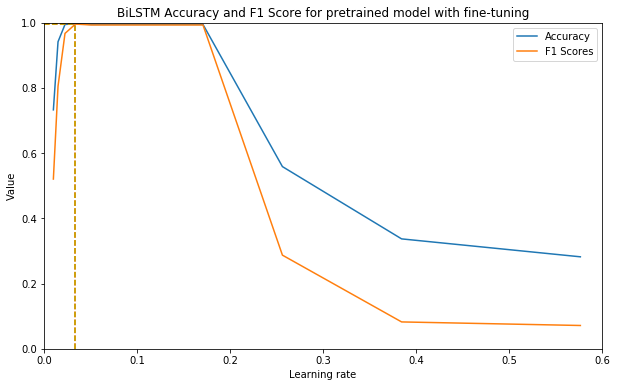

In [38]:
plt.figure(figsize=(10,6))
plt.xlim([0, 0.6])
plt.ylim([0, 1])
plt.plot(lr_list,accuracy_list,label='Accuracy')
plt.plot(lr_list,f1_list,label='F1 Scores')
plt.plot([0, ps_x_accu],[ps_y_accu,ps_y_accu], c='r', linestyle = '--')
plt.plot([ps_x_accu, ps_x_accu],[0,ps_y_accu], c='r', linestyle = '--')



plt.plot([0, ps_x_f1],[ps_y_f1,ps_y_f1], c='y', linestyle = '--')
plt.plot([ps_x_f1, ps_x_f1],[0,ps_y_f1], c='y', linestyle = '--')

ps_coord_str_accu = "max: " + str((lr_list[argmax_accu],round(accuracy_list[argmax_accu],3)))
plt.title("BiLSTM Accuracy and F1 Score for pretrained model with fine-tuning")
plt.xlabel('Learning rate')
plt.ylabel('Value')
plt.legend()
# plt.show()
plt.savefig("../visualization/out_bilstm_pre_fine.jpg")

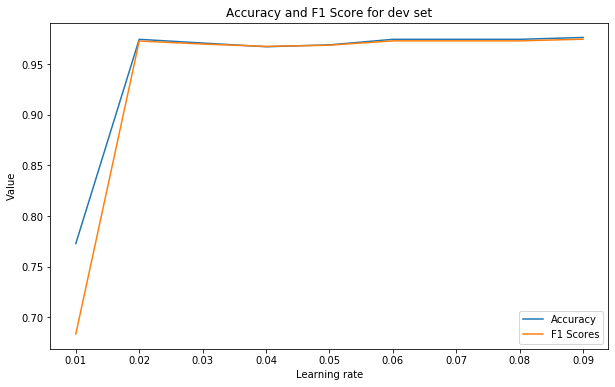

In [112]:
# plt.figure(figsize=(10,6))
# plt.plot(*zip(*accuracy_store),label='Accuracy')
# plt.plot(*zip(*f1_store),label='F1 Scores')
# plt.title("BiLSTM Accuracy and F1 Score for ")
# plt.xlabel('Learning rate')
# plt.ylabel('Value')
# plt.legend()
# # plt.show()
# plt.savefig("out_bilstm_rand.jpg")